In [1]:
#Developed by Christopher Hohman on Sept 27th, 2022
#Contact: chohman@uwyo.edu, (860) 336-1302
#This code follows the position of the sounding, and finds the corresponding model variables to plot a comparison Skew-T

In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wrf import getvar, interplevel, to_np, get_basemap, ll_to_xy,latlon_coords,latlon_coords, smooth2d,get_cartopy, cartopy_xlim, cartopy_ylim
import pandas as pd
from netCDF4 import Dataset
import netCDF4
import h5py as h5
import csv
from scipy import stats
import seaborn as sns
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units

In [3]:
def u_and_v(wind_direction, wind_speed):
    import math
    degree = ((270-wind_direction)*np.pi/180)
    u = math.cos(degree)*wind_speed
    v = math.sin(degree)*wind_speed
    return (u, v)
def es(T):
    return (610.7*np.exp(((2500800+(4218-1870.4)*273.16)*(1/273.16-1/T)-(4218-1870.4)*np.log(T/273.16))/461.51))

def Td(RH, es):
    e = RH * es
    Td = 1/((1/273.16) - (np.log(e/611)*461/2500000))
    return(Td)
def degree_to_decimal(lat_degree,lat_minute,lat_second,lon_degree,lon_minute,lon_second):
    #= -115° + -59'/60 + -24.4"/3600
    lat = (lat_degree) + (lat_minute/60) + (lat_second/3600)
    lon = ((lon_degree) + (lon_minute/60) + (lon_second/3600))*-1
    return(lat, lon)

In [4]:
def wrf_pres(P,PB):
    return (P+PB) #in Pa

def wrf_height(PH,PHB):
    return (PH+PHB)/9.81

def wrf_theta(PTEMP):
    return (PTEMP+300.)

def wrf_temp(THETA,PRES):
    return (THETA)*(PRES/1000.)**(.2854) # in hPa
def es(T):
    return (610.7*np.exp(((2500800+(4218-1870.4)*273.16)*(1/273.16-1/T)-(4218-1870.4)*np.log(T/273.16))/461.51))
def mean(data):
    mean = sum(data)/len(data)
    return(mean)

In [5]:
def file_info(name):
    filename = name
    picname = "numbercon_" + filename[19:27] + ".png"
    ncfile2 = Dataset(filename)
    ncfile = h5.File(filename, 'r')
    ds = netCDF4.Dataset(filename)
    cloud_mr = ncfile['QCLOUD'][:].squeeze() *1000
    P = ncfile['P'][:].squeeze()
    PB = ncfile['PB'][:].squeeze()
    PHB = ncfile['PHB'][:].squeeze()
    PH = ncfile['PH'][:].squeeze()
    lat = ncfile['XLAT'][:].squeeze()
    lon = ncfile['XLONG'][:].squeeze()
    u_m = getvar(ncfile2, "ua", units = "m s-1", meta = False)
    v_m = getvar(ncfile2, "va", units = "m s-1", meta = False)
    dew =  getvar(ncfile2, "td", units = "degC", meta = False)
    model_lat =  getvar(ncfile2, "lat", meta = False)
    model_lon =  getvar(ncfile2, "lon", meta = False)
    PRES = wrf_pres(P,PB)/100
    HEIGHT = wrf_height(PH,PHB)
    THETA = ncfile['T'][:]
    THETA = wrf_theta(THETA)
    TEMP = wrf_temp(THETA,PRES).squeeze()
    TEMP= TEMP - 273.16
    return(cloud_mr,HEIGHT, PRES, ncfile2, TEMP,u_m,v_m, dew, model_lat, model_lon)

In [6]:
file_list = ["wrfout_d01_2017-01-08_01:50:00","wrfout_d01_2017-01-08_01:55:00","wrfout_d01_2017-01-08_02:00:00","wrfout_d01_2017-01-08_02:05:00","wrfout_d01_2017-01-08_02:10:00","wrfout_d01_2017-01-08_02:15:00","wrfout_d01_2017-01-08_02:20:00"]

In [8]:
#open the Sounding CSV File
x = open("Crouch_02Z.csv", "r")

#Deliminate it with commas to grab the observed values
data = csv.reader(x, delimiter =",")

#These are lists that get filled with the station's pressure, temperature, dewpoint, U, and V compontent of the wind
#With the first index starting at ground level, at the final the top of the sounding.
pres_list = []
temp_list = []
dew_list = []
u_ob = []
v_ob = []

#This variable is changed everytime we go up one step in the sounding. It's set to 1000 so it triggers the if statment
#that checks if pressure, temperature, and dew point aren't 9999 (See below)
current_pressure = 1000
new_pressure = 1000
lat_list = []
lon_list = []
time_list = []
#Reading the CSV file one line at a time.
for line in data:
        #Checks to see if we're below 280 mb, and that the data is recorded:
        if new_pressure > 280 and line[5] != "//" and line[7] != "//":
            #Making each variable a float
            new_pressure = float(line[5])
            time = line[1]
            t = float(line[6])
            lat_degree = int(line[3][0:2])
            lat_minute = int(line[3][3:5])
            lat_second = float(line[3][6:10])
            lon_degree = int(line[4][1:4])
            lon_minute = int(line[4][5:7])
            lon_second = float(line[4][8:12])
            lat, lon = degree_to_decimal(lat_degree,lat_minute,lat_second,lon_degree,lon_minute,lon_second)
            #This is multiplied by .01 because we use it to calculate the dew point 
            RH = float(line[7])* .01
            wind_speed = float(line[8])
            wind_direction = float(line[9])
            u_com, v_com = u_and_v(wind_direction, wind_speed)
            
            #These if statements fill the variable lists if they're below 9999, and calculates dewpoint temperature
            if t < 9800:
                sat_vap = es(t+273.16)
                dew = Td(RH, sat_vap) - 273.16      
            if new_pressure < 9800 and t < 9800 and dew < 9800:
                pres_list.append(new_pressure)
                temp_list.append(t)
                dew_list.append(dew)
                lat_list.append(lat)
                lon_list.append(lon)
                time_list.append(time)
                try:
                    u_ob.append(float(u_com))
                    v_ob.append(float(v_com))
                except:
                    i = 3
    
u_ob = np.array(u_ob)
v_ob = np.array(v_ob)

In [10]:
#This is a counter that loops through each instance of the latitude list created above
counter = 0

#Getting the first file from the inputed file list
cloud_mr,HEIGHT, PRES, ncfile2, TEMP, u_m, v_m, model_dew, model_lat, model_lon = file_info(file_list[0])

#Getting the initial postion of the sounding, and finding the corresponding point in the model
model_y,model_x =ll_to_xy(ncfile2, lat_list[0],lon_list[0], False)

#This is a pressure that we compare to in the upcoming loop
climbing_pressure = PRES[0,model_y,model_x]

#List we add the model temperature to, to plot later
temp_model = []

#These are the lists of averaged environmental temperatures
envi_temp = []
obs_u = []
obs_v = []

#Lists that we'll add the modeled u and v component, and modeled dew point
u_m_list = []
v_m_list = []
dew_m_list = []
std_dew = []

#This is a list we add environmetnal temperatures and wind components to until we average them across a single gridbox (Appened to envi_temp above)
adding_temp = []
adding_u = []
adding_v = []
adding_dew = []
dew_envi = []
std_temp = []

#Keeping track of pressure to use for plotting later
pressure_list = []

#Counter that keep tracks of the model's altitude argument
presct = 0

#The idea with this loop is it loops through the modeled pressure until it reaches the starting pressure of the sounding

while climbing_pressure > pres_list[0]:
    climbing_pressure = PRES[presct,model_y,model_x]
    presct = presct + 1

print(PRES[0:10, model_x,model_y])
#This counter is used to switch to a new file when the time flips to either 00:00 or 05:00
timelistindex = 0

#Looping over the entire list of lat and lon
while counter < len(lat_list):
    
    #Get the lat and lon from the list
    lat = lat_list[counter]
    lon = lon_list[counter]
    
    #Add the temperature, dew point, and wind to a list to be averaged later
    adding_temp.append(temp_list[counter])
    adding_u.append(u_ob[counter])
    adding_v.append(v_ob[counter])
    adding_dew.append(dew_list[counter])
    
    #Take the current pressure we're at
    test_pressure = pres_list[counter]
    #Take the current time we're at
    time = time_list[counter]
    
    #This if statement looks to see if the time has changed by 5 minutes. If it has, then get the next file name
    if (time[3:7] == "5:00" or time[3:7] == "0:00"):
        timelistindex = timelistindex + 1
        cloud_mr,HEIGHT, PRES, ncfile2, TEMP, u_m, v_m, model_dew, model_lat, model_lon = file_info(file_list[timelistindex])
    
    #If the pressure we're currently at is less than the model pressure, then we have reached the top of the modeled grid box, and it it's time
    #to average the temperature list together to get one environmental temperature for that gridbox
    if test_pressure < climbing_pressure:
        
        #Add the modeled pressure to a list to use for plotting later
        pressure_list.append(climbing_pressure)
        
        #Get the mean of the temperature and wind list over the gridspace
        e_temp = np.mean(adding_temp)
        u = np.mean(adding_u)
        v = np.mean(adding_v)
        #Add that mean to a list to plot later
        envi_temp.append(e_temp)
        std_temp.append(np.std(adding_temp))
        obs_u.append(u)
        obs_v.append(v)
        dew_envi.append(np.mean(adding_dew))
        std_dew.append(np.std(adding_dew))
        
        #Get the position of the sounding
        model_y,model_x =ll_to_xy(ncfile2, lat,lon, meta = False)
        #Find that same position in the model
        temp_model.append(TEMP[presct, model_x,model_y])
        u_m_list.append(u_m[presct, model_x,model_y])
        v_m_list.append(v_m[presct, model_x,model_y])
        dew_m_list.append(model_dew[presct, model_x,model_y])

        #Go up one more gridspace, that way we can average through the next box
        presct = presct + 1
        #The new pressure of the gridspace above the one we just averaged over
        climbing_pressure = PRES[presct, model_x,model_y]
        #Clear the environmental lists used to average over
        adding_temp = []
        adding_u = []
        adding_v = []
        adding_dew = []
        
    #Go to the next point in the observed data
    counter = counter + 1
        

[893.78925 891.7491  889.6777  887.5419  885.3686  883.1052  880.74365
 878.2584  875.6325  872.8283 ]


55
55


3.1335475917149997


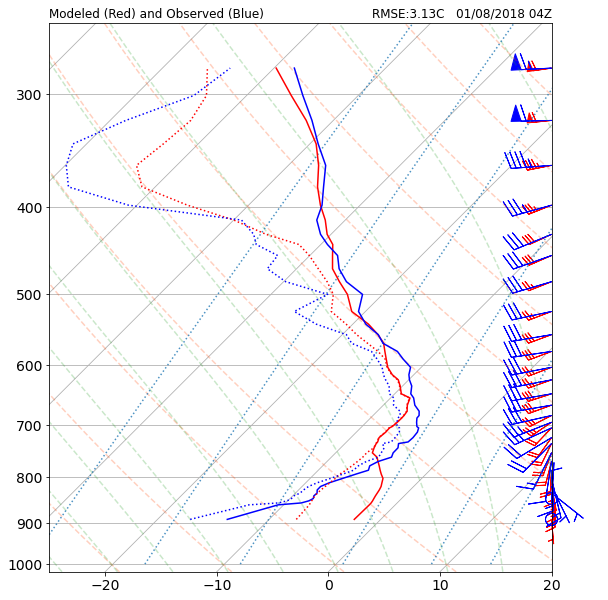

In [53]:
u = np.array(u_m_list)
v = np.array(v_m_list)
# Change default to be better for skew-T
fig = plt.figure(figsize=(9, 11))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(np.array(pressure_list), np.array(temp_model), 'red')
skew.plot(np.array(pressure_list), np.array(envi_temp), 'blue')
skew.plot(np.array(pressure_list), np.array(dew_m_list), 'red', linestyle = "dotted")
skew.plot(np.array(pressure_list), np.array(dew_envi), 'blue', linestyle = "dotted")
#skew.plot(pres_list, Td, 'g')
skew.plot_barbs(pressure_list[::2], u[::2], v[::2], y_clip_radius=0.03, color = "red",length = 7)
skew.plot_barbs(pressure_list[::2], obs_u[::2], obs_v[::2], y_clip_radius=0.03, color = "blue", length = 9)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-25, 20)
skew.ax.set_ylim(1020, 250)
skew.ax.xaxis.set_tick_params(labelsize = 14)
skew.ax.yaxis.set_tick_params(labelsize = 14)
#plt.xlabel("°C", size = 15)
#plt.ylabel("hPa", size = 15)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')
ct = 0
difference_list = []
for m_t in temp_model:
    m_t = str(m_t)
    if m_t != 'nan':
        m_t = float(m_t)
        difference_list.append((m_t - envi_temp[ct])**2)
        ct = ct + 1
r_sum = sum(difference_list)
RMSE = (r_sum/ct)**(1/2)
print(RMSE)

#Add RMSE
rmse_text = "RMSE:"+ str(RMSE)[0:4] + 'C   01/08/2018 04Z'
# Add some descriptive titles
plt.title('Modeled (Red) and Observed (Blue)', loc='left', size = 12)
#plt.title('Modeled Crouch Sounding', loc='left', size = 13)
plt.title(rmse_text, loc='right', size = 12)

plt.show()
#fig.savefig("Model_and_Observed_Sounding_08_11Z_Boise.png")
fig.savefig("Test_Sounding")

In [25]:
upper_temp_std = np.array(envi_temp) + np.array(std_temp)*2
lower_temp_std = np.array(envi_temp) - np.array(std_temp)*2
upper_dew_std = np.array(dew_envi) + np.array(std_dew)
lower_dew_std = np.array(dew_envi) - np.array(std_dew)
print(len(lower_temp_std))

55


3.1335475917149997


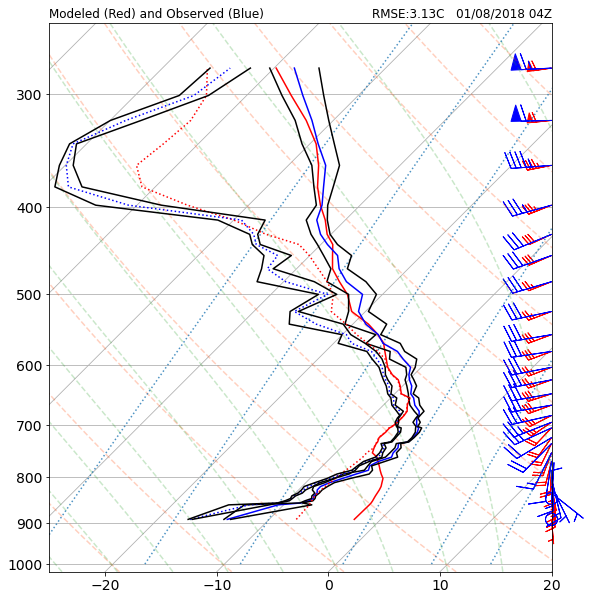

In [29]:
u = np.array(u_m_list)
v = np.array(v_m_list)
# Change default to be better for skew-T
fig = plt.figure(figsize=(9, 11))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(np.array(pressure_list), np.array(temp_model), 'red')
skew.plot(np.array(pressure_list), np.array(envi_temp), 'blue')
skew.plot(np.array(pressure_list), np.array(upper_temp_std), 'black')
skew.plot(np.array(pressure_list), np.array(lower_temp_std), 'black')

skew.plot(np.array(pressure_list), np.array(dew_m_list), 'red', linestyle = "dotted")
skew.plot(np.array(pressure_list), np.array(dew_envi), 'blue', linestyle = "dotted")
skew.plot(np.array(pressure_list), np.array(upper_dew_std), 'black')
skew.plot(np.array(pressure_list), np.array(lower_dew_std), 'black')
#skew.plot(pres_list, Td, 'g')
skew.plot_barbs(pressure_list[::2], u[::2], v[::2], y_clip_radius=0.03, color = "red",length = 7)
skew.plot_barbs(pressure_list[::2], obs_u[::2], obs_v[::2], y_clip_radius=0.03, color = "blue", length = 9)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-25, 20)
skew.ax.set_ylim(1020, 250)
skew.ax.xaxis.set_tick_params(labelsize = 14)
skew.ax.yaxis.set_tick_params(labelsize = 14)
#plt.xlabel("°C", size = 15)
#plt.ylabel("hPa", size = 15)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')
ct = 0
difference_list = []
for m_t in temp_model:
    m_t = str(m_t)
    if m_t != 'nan':
        m_t = float(m_t)
        difference_list.append((m_t - envi_temp[ct])**2)
        ct = ct + 1
r_sum = sum(difference_list)
RMSE = (r_sum/ct)**(1/2)
print(RMSE)

#Add RMSE
rmse_text = "RMSE:"+ str(RMSE)[0:4] + 'C   01/08/2018 04Z'
# Add some descriptive titles
plt.title('Modeled (Red) and Observed (Blue)', loc='left', size = 12)
#plt.title('Modeled Crouch Sounding', loc='left', size = 13)
plt.title(rmse_text, loc='right', size = 12)

plt.show()
#fig.savefig("Model_and_Observed_Sounding_08_11Z_Boise.png")
fig.savefig("ERA5_ALL")

In [ ]:
print(temp_list[0:5])

In [ ]:
print(presct)

In [ ]:
filename = "wrfout_d01_2017-01-08_02:45:00"
picname = "numbercon_" + filename[19:27] + ".png"
ncfile2 = Dataset(filename)
ncfile = h5.File(filename, 'r')
ds = netCDF4.Dataset(filename)
cloud_mr = ncfile['QCLOUD'][:].squeeze() *1000
P = ncfile['P'][:].squeeze()
PB = ncfile['PB'][:].squeeze()
PHB = ncfile['PHB'][:].squeeze()
PH = ncfile['PH'][:].squeeze()
model_lat =  getvar(ncfile2, "lat", meta = False)
model_lon =  getvar(ncfile2, "lon", meta = False)
PRES = wrf_pres(P,PB)/100
HEIGHT = wrf_height(PH,PHB)
THETA = ncfile['T'][:]
THETA = wrf_theta(THETA)
TEMP = wrf_temp(THETA,PRES).squeeze()
TEMP= TEMP - 273.16

In [ ]:
model_y,model_x =ll_to_xy(ncfile2, lat_list[0],lon_list[0], meta = False)

print(lat_list[0])
print(lon_list[0])
print(model_lat[318, 406])
print(model_lon[318, 406])
print(PRES[0:10, 318, 406])
print(pres_list[0:10])
print(model_x)
print(model_y)